In [1]:
#Required Library Import
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#input news sentiment analyzed file
news_file="C:/Users/anish/Downloads/Fundamentals of AI/Week5-Final Project/combined_stock_data.csv"
news_df = pd.read_csv(news_file, parse_dates=[1])

In [3]:
#input stock price file 
stockprices_file = "C:/Users/anish/Downloads/Fundamentals of AI/Week5-Final Project/DJIA_table.csv"
stock_df = pd.read_csv(stockprices_file, parse_dates=[0])

In [4]:
#merge into single df
join_dataframe = news_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_df, how='inner', on='Date', left_index=True)
join_dataframe.head()
cols = list(join_dataframe)
cols.append(cols.pop(cols.index('Label')))
join_dataframe = join_dataframe.loc[:, cols]
join_dataframe.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


In [5]:
#check data type
print(join_dataframe.dtypes)

Date            datetime64[ns]
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Adj Close              float64
Label                    int64
dtype: object


In [6]:
#dataframe cleaning
join_dataframe['Volume'] = join_dataframe['Volume'].astype(float)
join_dataframe.index = join_dataframe.index.sort_values()
join_dataframe.head()

,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


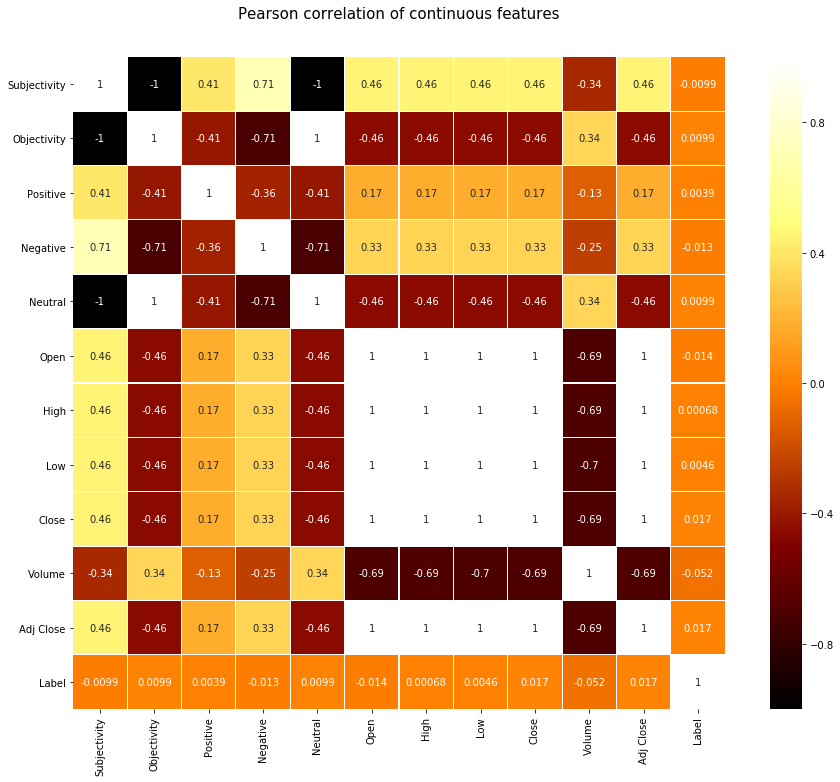

In [7]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(join_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [8]:
#check for null values and replace with mean
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    join_dataframe[col] = join_dataframe[col].fillna(join_dataframe[col].mean())
join_dataframe.isnull().sum()

Date            0
Subjectivity    0
Objectivity     0
Positive        0
Negative        0
Neutral         0
Open            0
High            0
Low             0
Close           0
Volume          0
Adj Close       0
Label           0
dtype: int64

In [9]:
#declare input and output dfs
inputdf = join_dataframe.loc[:,'Subjectivity':'Adj Close']
outputdf = join_dataframe.loc[:,'Label']

#split train and test datasets to 80:20 % ratio
train_size = int(len(inputdf.index) * 0.8)
print(len(outputdf))
print(train_size)
X_train, X_test = inputdf.loc[0:train_size, :], inputdf.loc[train_size: len(inputdf.index), :]
Y_train, Y_test = outputdf[0:train_size+1], outputdf.loc[train_size: len(outputdf.index)]

#Count verifications
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('Y Training Observations: %d' % (len(Y_train)))
print('Y Testing Observations: %d' % (len(Y_test)))

1989
1591
X Training Observations: 1592
X Testing Observations: 398
Y Training Observations: 1592
Y Testing Observations: 398


In [10]:
#running all models and comparing accuracies

models = []
models.append(('LogisticRegression' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NaiveBayes' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RandomForest' , RandomForestClassifier(n_estimators=50)))

for name, model in models:
    clf = model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LogisticRegression: 0.507537688442211
KNN: 0.4623115577889447
CART: 0.6055276381909548
NaiveBayes: 0.5125628140703518


C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM: 0.507537688442211
RandomForest: 0.5804020100502513


In [11]:
#scaling data

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_test)


In [12]:
#Logistic Regression

model_logreg = LogisticRegression()
model_logreg.fit(rescaledX, Y_train)
predictions = model_logreg.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.871859296482412
confusion matrix: 
[[145  51]
 [  0 202]]
classification report: 
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       196
           1       0.80      1.00      0.89       202

    accuracy                           0.87       398
   macro avg       0.90      0.87      0.87       398
weighted avg       0.90      0.87      0.87       398



C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
#Decision Tree

model_cart = DecisionTreeClassifier()
model_cart.fit(rescaledX, Y_train)
predictions = model_cart.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.6030150753768844
confusion matrix: 
[[ 74 122]
 [ 36 166]]
classification report: 
              precision    recall  f1-score   support

           0       0.67      0.38      0.48       196
           1       0.58      0.82      0.68       202

    accuracy                           0.60       398
   macro avg       0.62      0.60      0.58       398
weighted avg       0.62      0.60      0.58       398



In [14]:
#KNN

model_knn = KNeighborsClassifier()
model_knn.fit(rescaledX, Y_train)
predictions = model_knn.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.5100502512562815
confusion matrix: 
[[ 61 135]
 [ 60 142]]
classification report: 
              precision    recall  f1-score   support

           0       0.50      0.31      0.38       196
           1       0.51      0.70      0.59       202

    accuracy                           0.51       398
   macro avg       0.51      0.51      0.49       398
weighted avg       0.51      0.51      0.49       398



In [15]:
#NaiveBayes

model_naivebayes = GaussianNB()
model_naivebayes.fit(rescaledX, Y_train)
predictions = model_naivebayes.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.5125628140703518
confusion matrix: 
[[ 50 146]
 [ 48 154]]
classification report: 
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       196
           1       0.51      0.76      0.61       202

    accuracy                           0.51       398
   macro avg       0.51      0.51      0.48       398
weighted avg       0.51      0.51      0.48       398



In [16]:
#Support Vector Machine

model_SVM = SVC()
model_SVM.fit(rescaledX, Y_train)
predictions = model_SVM.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.507537688442211
confusion matrix: 
[[ 48 148]
 [ 48 154]]
classification report: 
              precision    recall  f1-score   support

           0       0.50      0.24      0.33       196
           1       0.51      0.76      0.61       202

    accuracy                           0.51       398
   macro avg       0.50      0.50      0.47       398
weighted avg       0.51      0.51      0.47       398



In [17]:
#Random Forest

model_RF = RandomForestClassifier(n_estimators=50)
model_RF.fit(rescaledX, Y_train)
predictions = model_RF.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.5753768844221105
confusion matrix: 
[[ 59 137]
 [ 32 170]]
classification report: 
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       196
           1       0.55      0.84      0.67       202

    accuracy                           0.58       398
   macro avg       0.60      0.57      0.54       398
weighted avg       0.60      0.58      0.54       398



In [18]:
#L2 regularization parameter estimation
weights, params = [], []
for c in np.arange(0, 10):
   lr = LogisticRegression(C=10**c, random_state=0)
   lr.fit(rescaledX, Y_train)
   weights.append(lr.coef_[0])
   params.append(10**c)

weights = np.array(weights)

C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to '

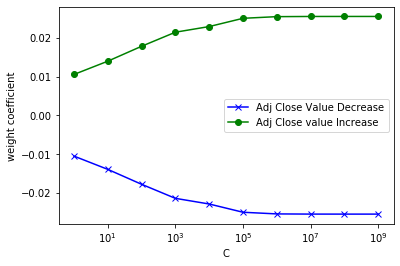

In [19]:
#parameter estimation using plot
plt.plot(params, weights[:, 0], color='blue', marker='x', label='Adj Close Value Decrease')
plt.plot(params, weights[:, 1], color='green',  marker='o', label='Adj Close value Increase')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='right')
plt.xscale('log')
plt.show()

In [25]:
#tuned logistic regression
model_logreg1 = LogisticRegression(C=1, random_state = 0)
model_logreg1.fit(rescaledX, Y_train)
predictions = model_logreg1.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(Y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(Y_test, predictions))
print("classification report: ")
print(classification_report(Y_test, predictions))


accuracy score:
0.871859296482412
confusion matrix: 
[[145  51]
 [  0 202]]
classification report: 
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       196
           1       0.80      1.00      0.89       202

    accuracy                           0.87       398
   macro avg       0.90      0.87      0.87       398
weighted avg       0.90      0.87      0.87       398



C:\Users\anish\Documents\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
